<a href="https://colab.research.google.com/github/andersonjhones/-MORNING-STAR/blob/main/Case_MORNING_STAR_Anderson_Jhones_Passos_Nascimento.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###**Desafio do processo seletivo da Morning Star - Cientista de Dados.**

**Desafio - Desenvolva um modelo, treinado com os dados contidos no
aquivo dados_pocos.csv, onde passado um poço como entrada, o mesmo
retorne uma lista com os 4 poços mais correlatos (com características mais próximas) ao poço de entrada.**

**Características de um poço:**

**Nome:** Nome que identifica o projeto do poço

**Fase:** É o número da fase. Um projeto é dividido em fases.

**Tipo Poço:** Existem aqui 2 tipos de poços **VERTICAL** ou **HORIZONTAL**.

**LDA (Lâmina D'Água):** LDA é o valor em metros, que corresponde a distância entre a
superfície do mar até o ponto de perfuração em poços subaquático.

**Diâmetro Fase:** Para cada fase da perfuração pode-se usar uma broca com diâmetro
diferente. Aqui o diâmetro é descrito em polegadas.

**Metragem:** Valor em metros que corresponde ao total perfurado naquela fase.

**NFases:** Corresponde ao número total de fases que o projeto exigiu.

**Importações de bibliotecas utilizadas.**

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as m
m.rcParams['axes.labelsize'] = 14
m.rcParams['xtick.labelsize'] = 12
m.rcParams['ytick.labelsize'] = 12
from matplotlib.pylab import rcParams 
rcParams['figure.figsize'] = 20,5
import numpy as np
from sklearn import metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix,  classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder
import pathlib
from math import sqrt
from imblearn.over_sampling import ADASYN
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from numpy import mean
from numpy import std

**Carregamento do conjunto de dados**

In [2]:
dataset_case = 'https://github.com/andersonjhones/-MORNING-STAR/raw/main/dados_pocos.csv'
dados= pd.read_csv(dataset_case)

**Visualizando as primeiras 5 linhas do conjunto de dados**

In [3]:
dados.head()

,id,nome_poco,fase,tipo_poco,lda,diametro_fase,metragem,nfases
0,0,6C5G4M,1,VERTICAL,598.0,26,607.0,4
1,1,6C5G4M,2,VERTICAL,598.0,17 1/2,1306.0,4
2,2,6C5G4M,3,VERTICAL,598.0,12 1/4,1201.0,4
3,3,6C5G4M,4,VERTICAL,598.0,8 1/2,1445.0,4
4,4,8030JC,1,VERTICAL,0.0,17 1/2,410.0,3


###**Conhecendo os dados e tratando-os.**

**Número de linhas e colunas do dataset**

In [4]:
print('O número de linhas e colunas do conjunto de dados é: \n', dados.shape)

O número de linhas e colunas do conjunto de dados é: 
 (10649, 8)


**Informações sobre o tipo dos dados, se inteiro ou object, por exemplo, e também pode-se perceber que o conjunto de dados não apresenta dados faltantes.**

In [ ]:
dados.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10649 entries, 0 to 10648
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             10649 non-null  int64  
 1   nome_poco      10649 non-null  object 
 2   fase           10649 non-null  int64  
 3   tipo_poco      10649 non-null  object 
 4   lda            10649 non-null  float64
 5   diametro_fase  10649 non-null  object 
 6   metragem       10649 non-null  float64
 7   nfases         10649 non-null  int64  
dtypes: float64(2), int64(3), object(3)
memory usage: 665.7+ KB


**Pode-se confirmar abaixo que não há dados nulos.**

In [5]:
dados.isnull().sum()

id               0
nome_poco        0
fase             0
tipo_poco        0
lda              0
diametro_fase    0
metragem         0
nfases           0
dtype: int64

**Com o comando abaixo foi constatado que há 3186 poços distintos.**

In [6]:
dados['nome_poco'].nunique()

3186

**Observando a coluna "tipo_poco" pode-se ver que o dataset apresenta além dos dois tipos de poços mencionados no arquivo pdf do case (Vertical e Horizontal), também o tipo Direcional, além de 151 observações com valores 0.**

In [7]:
dados['tipo_poco'].value_counts()

VERTICAL      4971
DIRECIONAL    3812
HORIZONTAL    1715
0              151
Name: tipo_poco, dtype: int64

**Índices da coluna "tipo_poco" com valor zero.**

In [8]:
dados[dados['tipo_poco']=='0']

,id,nome_poco,fase,tipo_poco,lda,diametro_fase,metragem,nfases
324,324,6YYR78,1,0,1671.0,36,63.0,1
1377,1377,WK7P95,1,0,24.0,26,67.0,4
1378,1378,WK7P95,2,0,24.0,17 1/2,692.0,4
1379,1379,WK7P95,3,0,24.0,12 1/4,1649.0,4
1380,1380,WK7P95,4,0,24.0,8 1/2,1002.0,4
...,...,...,...,...,...,...,...,...
10644,10644,E25RS3,1,0,0.0,30,60.0,1
10645,10645,AR3826,1,0,0.0,30,50.0,1
10646,10646,XO8Q23,1,0,1282.0,36,56.0,1
10647,10647,7RK405,1,0,0.0,26,49.0,1


**Com o intuito de comprometer o dataset original carregado, fez-se uma cópia do conjunto de dados chamada dados2.**

In [9]:
dados2=dados.copy()

**A coluna "diametro_fase" está em formato de texto (object), então foram realizados alguns passos em código para deixar a coluna como float. Abaixo está sendo feita uma separação pelo espaço entre a parte inteira e a parte decimal.**

In [10]:
dados2[['diametro_inteiro', 'diametro_decimal_texto']] = dados2['diametro_fase'].str.split(' ', expand=True)

In [11]:
dados2.head()

,id,nome_poco,fase,tipo_poco,lda,diametro_fase,metragem,nfases,diametro_inteiro,diametro_decimal_texto
0,0,6C5G4M,1,VERTICAL,598.0,26,607.0,4,26,None
1,1,6C5G4M,2,VERTICAL,598.0,17 1/2,1306.0,4,17,1/2
2,2,6C5G4M,3,VERTICAL,598.0,12 1/4,1201.0,4,12,1/4
3,3,6C5G4M,4,VERTICAL,598.0,8 1/2,1445.0,4,8,1/2
4,4,8030JC,1,VERTICAL,0.0,17 1/2,410.0,3,17,1/2


**Transformação da parte inteira do diâmetro da fase em polegadas de object para float.**

In [12]:
dados2['diametro_inteiro'] = dados2['diametro_inteiro'].astype(float)

**Separação da parte decimal, em formato de texto, pela barra que simboliza a divisão de um número pelo outro.**

In [13]:
dados2[['diametro_decimal1', 'diametro_decimal2']] = dados2['diametro_decimal_texto'].str.split('/', expand=True)

In [14]:
dados2.head()

,id,nome_poco,fase,tipo_poco,lda,diametro_fase,metragem,nfases,diametro_inteiro,diametro_decimal_texto,diametro_decimal1,diametro_decimal2
0,0,6C5G4M,1,VERTICAL,598.0,26,607.0,4,26.0,None,None,None
1,1,6C5G4M,2,VERTICAL,598.0,17 1/2,1306.0,4,17.0,1/2,1,2
2,2,6C5G4M,3,VERTICAL,598.0,12 1/4,1201.0,4,12.0,1/4,1,4
3,3,6C5G4M,4,VERTICAL,598.0,8 1/2,1445.0,4,8.0,1/2,1,2
4,4,8030JC,1,VERTICAL,0.0,17 1/2,410.0,3,17.0,1/2,1,2


**Transformação das partes decimais de object para float.**

In [15]:
dados2['diametro_decimal1'] = dados2['diametro_decimal1'].astype(float)
dados2['diametro_decimal2'] = dados2['diametro_decimal2'].astype(float)

**Criação da coluna "diametro_decimal_total".**

In [16]:
dados2['diametro_decimal_total'] = dados2['diametro_decimal1']/dados2['diametro_decimal2']

In [17]:
dados2.head()

,id,nome_poco,fase,tipo_poco,lda,diametro_fase,metragem,nfases,diametro_inteiro,diametro_decimal_texto,diametro_decimal1,diametro_decimal2,diametro_decimal_total
0,0,6C5G4M,1,VERTICAL,598.0,26,607.0,4,26.0,None,NaN,NaN,NaN
1,1,6C5G4M,2,VERTICAL,598.0,17 1/2,1306.0,4,17.0,1/2,1.0,2.0,0.50
2,2,6C5G4M,3,VERTICAL,598.0,12 1/4,1201.0,4,12.0,1/4,1.0,4.0,0.25
3,3,6C5G4M,4,VERTICAL,598.0,8 1/2,1445.0,4,8.0,1/2,1.0,2.0,0.50
4,4,8030JC,1,VERTICAL,0.0,17 1/2,410.0,3,17.0,1/2,1.0,2.0,0.50


**A coluna "diametro_decimal_total" apresenta alguns valores NAN (Note a number), porque em alguns casos não havia a parte decimal e então vou colocado um valor NAN pela linguagem. Por esse motivo o valor NAN está sendo substituido por zero, caso contrário, quando fosse feita a soma com a parte inteira, a soma resultaria em um valor NAN.**

In [18]:
dados2['diametro_decimal_total']=dados2['diametro_decimal_total'].fillna(0)

In [19]:
dados2.head()

,id,nome_poco,fase,tipo_poco,lda,diametro_fase,metragem,nfases,diametro_inteiro,diametro_decimal_texto,diametro_decimal1,diametro_decimal2,diametro_decimal_total
0,0,6C5G4M,1,VERTICAL,598.0,26,607.0,4,26.0,None,NaN,NaN,0.00
1,1,6C5G4M,2,VERTICAL,598.0,17 1/2,1306.0,4,17.0,1/2,1.0,2.0,0.50
2,2,6C5G4M,3,VERTICAL,598.0,12 1/4,1201.0,4,12.0,1/4,1.0,4.0,0.25
3,3,6C5G4M,4,VERTICAL,598.0,8 1/2,1445.0,4,8.0,1/2,1.0,2.0,0.50
4,4,8030JC,1,VERTICAL,0.0,17 1/2,410.0,3,17.0,1/2,1.0,2.0,0.50


**Criação da coluna "dpolegaadastotal", que contém o diâmetro total em polegadas da fase.**

In [20]:
dados2['dpolegadastotal'] = dados2['diametro_inteiro']+dados2['diametro_decimal_total']

In [21]:
dados2.head()

,id,nome_poco,fase,tipo_poco,lda,diametro_fase,metragem,nfases,diametro_inteiro,diametro_decimal_texto,diametro_decimal1,diametro_decimal2,diametro_decimal_total,dpolegadastotal
0,0,6C5G4M,1,VERTICAL,598.0,26,607.0,4,26.0,None,NaN,NaN,0.00,26.00
1,1,6C5G4M,2,VERTICAL,598.0,17 1/2,1306.0,4,17.0,1/2,1.0,2.0,0.50,17.50
2,2,6C5G4M,3,VERTICAL,598.0,12 1/4,1201.0,4,12.0,1/4,1.0,4.0,0.25,12.25
3,3,6C5G4M,4,VERTICAL,598.0,8 1/2,1445.0,4,8.0,1/2,1.0,2.0,0.50,8.50
4,4,8030JC,1,VERTICAL,0.0,17 1/2,410.0,3,17.0,1/2,1.0,2.0,0.50,17.50


**O conjunto de dados chamado "dados_classificadores será usado posteriormente.**

In [22]:
dados_classificadores = dados2.copy()

**Exclusão de colunas desnecessárias na análise de correlação, que será aplicada.**

In [23]:
dados2.drop(['fase', 'id', 'diametro_fase', 'diametro_inteiro', 'diametro_decimal_texto',  'diametro_decimal1', 
             'diametro_decimal2', 'diametro_decimal_total'],  axis=1, inplace=True)

In [24]:
dados2.head()

,nome_poco,tipo_poco,lda,metragem,nfases,dpolegadastotal
0,6C5G4M,VERTICAL,598.0,607.0,4,26.00
1,6C5G4M,VERTICAL,598.0,1306.0,4,17.50
2,6C5G4M,VERTICAL,598.0,1201.0,4,12.25
3,6C5G4M,VERTICAL,598.0,1445.0,4,8.50
4,8030JC,VERTICAL,0.0,410.0,3,17.50


**Exclusão das linhas com o tipo do poço zerado. Algumas possibilidades poderiam ser feitas, como trocar o "0" por poços em maior quantidade, que é o caso do poço vertical, ou poderia ser perguntado ao setor de onde veio os dados se esta inclusão de zeros trata-se de um erro humano, ou o banco de dados foi corrompido, ou não se sabia o tipo do poço e por isso foi colocado zero, dentre outras possibilidades, mas neste caso preferiu-se excluir as linhas zeradas.**

In [25]:
indexzeros = dados2[dados2['tipo_poco'] == '0'].index

In [26]:
dados2.drop(indexzeros , inplace=True)

In [27]:
dados2['tipo_poco'].value_counts()

VERTICAL      4971
DIRECIONAL    3812
HORIZONTAL    1715
Name: tipo_poco, dtype: int64

**Com a exclusão das linhas zeradas da coluna "tipo_poco", o índice precisa ser resetado para ficar em ordem normal, pois os índices das linhas com zeros foram excluídos.**

In [28]:
dados2.reset_index(drop=True, inplace=True)

In [29]:
dados2.head()

,nome_poco,tipo_poco,lda,metragem,nfases,dpolegadastotal
0,6C5G4M,VERTICAL,598.0,607.0,4,26.00
1,6C5G4M,VERTICAL,598.0,1306.0,4,17.50
2,6C5G4M,VERTICAL,598.0,1201.0,4,12.25
3,6C5G4M,VERTICAL,598.0,1445.0,4,8.50
4,8030JC,VERTICAL,0.0,410.0,3,17.50


**Conferindo o shape do dataset pode-se perceber que 151 linhas foram deletadas.**

In [30]:
dados2.shape

(10498, 6)

### **Aplicação do classificador de máxima correlação (usando a distância cosseno).**

**Para a aplicação do primeiro algoritmo que será criado, visando encontrar os 4 poços mais correlacionados com o poço a ser dado como entreda (os atributos do poço), os dados serão agrupados pelo nome do poço e pelo número de fases, neste caso daria o mesmo que agrupar só pelo nome do poço, está sendo feita a média das colunas para a aplicação da similaridade por cosseno (medida de similaridade). A similaridade por cosseno é uma medida da similareda de entre dois vetores num espaço vetorial que avalia o valor do cosseno do ângulo compreendido entre eles. Esta função trigonométrica proporciona um valor igual a 1 se o ângulo compreendido é zero, isto é se ambos vetores apontam a um mesmo lugar. Para esse algoritmo a coluna fase também foi excluída, pois decidiu-se não fazer a média das fases e sim deixar a coluna com o número total de fases "nfases" no cálculo das 4 maiores correlações. Serão usados os atributos "nfases",	"lda",	"metragem" e	"dpolegadastotal" no cálculo das similaridades.**

In [31]:
dados3 = dados2.groupby(['nome_poco', 'nfases']).mean().reset_index()
dados3.head()

,nome_poco,nfases,lda,metragem,dpolegadastotal
0,001L7P,6,2140.0,654.5,18.750
1,004E6L,1,1034.0,1983.0,12.250
2,0056I8,2,1195.0,559.0,26.750
3,0089FG,2,1723.0,920.5,16.125
4,00DL2O,1,1315.0,1078.0,8.500


**Shape dos dados depois de agrupados pelo nome do poço**

In [32]:
dados3.shape

(3120, 5)

**Através do comando describe foi possível constatar que a coluna "lda" também aparesenta valores zerados, pois o valor mínimo da coluna é zero. Na verdade, antes do agrupamento a coluna tinha 125 linhas zeradas, era uma possibilidade fazer a exclusão das linhas, mas preferiu-se manter as linhas, algumas zeradas foram substituídas pela média no agrupamento feito pelo tipo de poço ,pelo nome do poço e pelo número de fases, então a média dos valores de lda zerados foi feita segundo cada poço, por exemplo, um poço com duas fases, sendo uma zerada ficou com a média do valor dividido por dois, ou seja, (valor_existente_do_poço+0)/2. Preferiu-se fazer dessa forma do que excluir as linhas ou substituir o valor zero pela média ou mediana geral. Depois do agrupamento a coluna "lda" ainda ficou com 53 linhas zeradas, nessa parte os zeros foram substituídos pela média do valor da coluna, já que média e media estavam muito próximas para essa coluna.**

In [33]:
dados3['lda'].describe()

count    3120.000000
mean     1104.565994
std       679.331179
min         0.000000
25%       551.750000
50%      1094.000000
75%      1593.000000
max      2988.000000
Name: lda, dtype: float64

**Substituição das linhas zeradas de "lda" pela média da coluna.**

In [34]:
dados3['lda'][dados3['lda']==0].count()

53

In [35]:
dados3['lda'][dados3['lda'] > 0].mean()

1123.6537006847082

In [36]:
dados3.loc[dados3['lda'] ==0, 'lda'] = 1123.65370

In [37]:
dados3.loc[dados3['lda'] == 0]

,nome_poco,nfases,lda,metragem,dpolegadastotal


**A coluna "dpolegadastotal" antes do agrupamento também continha 7 linhas zeradas, da mesma forma preferiu-se não excluir as linhas. Quando foi feito o agrupamento a coluna não teve mais valores zerados.**

In [38]:
dados3['dpolegadastotal'][dados3['dpolegadastotal']==0].count()

0

**A coluna "metragem" antes do agrupamento também continha 480 linhas zeradas, da mesma forma preferiu-se não excluir as linhas, mesmo elas representando uma parte até significativa do dataset, entre 4 e 5% do total dos dados. Quando foi feito o agrupamento a coluna teve apenas 5 valores zerados restantes.**

**Substituição das linhas zeradas de "metragem" pela mediana da coluna. A média estava maior que a mediana, então preferiu-se substituir os valores zeros pela mediana, pois 50% dos dados estão abaixo da mediana, que é 692, e não acima como mostra a média de valor 711.**

In [39]:
dados3['metragem'].describe()

count    3120.000000
mean      711.353006
std       300.169367
min         0.000000
25%       519.265000
50%       692.100000
75%       875.700000
max      2638.000000
Name: metragem, dtype: float64

In [40]:
dados3['metragem'][dados3['metragem']==0].count()

5

In [41]:
dados3['metragem'][dados3['metragem'] > 0].median()

692.5

In [42]:
dados3.loc[dados3['metragem'] ==0, 'metragem'] = 692.5

In [43]:
dados3.loc[dados3['metragem'] == 0]

,nome_poco,nfases,lda,metragem,dpolegadastotal


In [44]:
dados3.shape

(3120, 5)

**Tendo em vista que a coluna "nome_poco" é em formato de texto e também não serve, nesse caso, para a análise de correlação. A coluna não foi utilizada nos cálculos. Foram utilizadas as 4 colunas restantes de dados3.** 

**O conjunto de dados chamado "dados_testes é justamente o conjunto separado para a entrada de dados e comparação com as observações restantes para obter a máxima correlação.**

In [135]:
dados_testes = dados3.iloc[0:5,1:]
dados_testes

,nfases,lda,metragem,dpolegadastotal
0,6,2140.0,654.5,18.750
1,1,1034.0,1983.0,12.250
2,2,1195.0,559.0,26.750
3,2,1723.0,920.5,16.125
4,1,1315.0,1078.0,8.500


**Dados de poços a serem comparados com as características do poço passadas como entrada.**

In [279]:
dados_pocos = dados3.iloc[5:, 1:]
dados_pocos.reset_index(drop=True, inplace=True)
dados_pocos.head()

,nfases,lda,metragem,dpolegadastotal
0,5,2270.0000,657.6,20.050000
1,1,1357.0000,692.0,12.250000
2,1,1123.6537,331.0,17.500000
3,6,81.0000,628.0,17.958333
4,2,89.0000,233.5,10.375000


**Entrada de poço para comparação com as características dos demais.**

In [282]:
Testes=dados_testes.iloc[0:1,0:].to_numpy()

**Aplicação do equacionamento da simiralidade por cosseno.**

In [284]:
dTestes = np.sqrt(np.sum(np.square(Testes)))

**Passando os dados dos poços para o formato do numpy.**

In [285]:
dados_pocos=dados_pocos.to_numpy()

In [291]:
dpocost=dados_pocos.T

**Lista vazia para receber os dados do loop for.**

In [286]:
conjunto1=[]

In [287]:
for i in range(len(dados_pocos)):
  dms = np.sqrt(np.sum(np.square(dados_pocos[i].T)))
  conjunto1.append(dms)
  

**Dados de saída do loop em formato de array numpy.**

In [289]:
dcpocos=np.array(conjunto1)

**Aplicação da equação que dará os resultados das similaridades entre os poços.**

In [293]:
Quatro_maiores_similaridades = Testes@dpocost/(dTestes*dcpocos)

**Mudando o shape dos dados para o formato de vetor coluna.**

In [294]:
Quatro_maiores_similaridades = Quatro_maiores_similaridades.reshape(-1)

**Coletando as 4 maiores similaridades com a busca de seus índices.**

In [295]:
kcosseno = 4

idxcosseno = np.argpartition(Quatro_maiores_similaridades, kcosseno)[-4:]
print('Os índices dos 4 poços mais correlacionados são: \n', idxcosseno)
print()
print('Os 4 poços mais correlacionados tem distância euclidiana de: \n', Quatro_maiores_similaridades[idxcosseno[:kcosseno]])

Os índices dos 4 poços mais correlacionados são: 
 [   9 3112    2    0]

Os 4 poços mais correlacionados tem distância euclidiana de: 
 [0.9992883  0.99794671 0.99992342 0.99988982]


**Poço passado como entrada de dados.**

In [296]:
dados_testes.iloc[0:1,0:]

,nfases,lda,metragem,dpolegadastotal
0,6,2140.0,654.5,18.75


In [297]:
dados3.iloc[0:1,:]

,nome_poco,nfases,lda,metragem,dpolegadastotal
0,001L7P,6,2140.0,654.5,18.75


**Visualização dos 4 poços mais similaris com o poço de entrada.**

In [299]:
dados_pocos[[9, 3112, 2, 0], :]

array([[5.00000000e+00, 2.13200000e+03, 5.65100000e+02, 2.12500000e+01],
       [3.00000000e+00, 1.61100000e+03, 3.82000000e+02, 1.99166667e+01],
       [1.00000000e+00, 1.12365370e+03, 3.31000000e+02, 1.75000000e+01],
       [5.00000000e+00, 2.27000000e+03, 6.57600000e+02, 2.00500000e+01]])

In [300]:
dados3.iloc[[14, 3117, 7, 5], :]

,nome_poco,nfases,lda,metragem,dpolegadastotal
14,01UR62,5,2132.0000,565.1,21.250000
3117,ZUSIAU,3,1611.0000,382.0,19.916667
7,00WI6A,1,1123.6537,331.0,17.500000
5,00OCZ3,5,2270.0000,657.6,20.050000


### **Aplicação do classificador de distância mínima ao centróide (usando a distância euclidiana).**

**Para a aplicação do algoritmo que será criado, visando encontrar os 4 poços mais correlacionados com o poço a ser dado como entreda (os atributos do poço), os dados serão agrupados pelo nome do poço e pelo número de fases, neste caso daria o mesmo que agrupar só pelo nome do poço, está sendo feita a média das colunas para a aplicação da distância euclidiana, a distância euclidiana é uma medida de distância que busca a menor distância entre dois pontos e pode ser provada pela aplicação repetida do teorema de Pitágoras. Para esse algoritmo a coluna fase também foi excluída, pois decidiu-se não fazer a média das fases e sim deixar a coluna com o número total de fases "nfases" no cálculo da distância. NO cálculo das 4 distâncias menores do poço passado (as 4 maiores correlações), serão usados os atributos "nfases",	"lda",	"metragem" e	"dpolegadastotal".**

**Lista vazia chamada "conjunto" para receber a distância euclidiana entre os pontos.**

In [48]:
conjunto = []

**Loop para aplicar o classificador de mínima distância para obter as 4 maiores correlações.**

In [49]:
for i in range(len(dados_pocos)):
  dist_ms = np.sqrt(np.sum(np.square((dados_testes.iloc[0:1,0:].to_numpy())-dados_pocos[i])))
  conjunto.append(dist_ms)

  

**Transformação de "conjunto" em um array numpy.**

In [50]:
A = np.array(conjunto)

**Coletando os 4 índices das menores distâncias e os valores das menores distâncias.**

In [51]:
k = 4

idx = np.argpartition(A, k)[:4]
print('Os índices dos 4 poços mais correlacionados são: \n', idx)
print()
print('Os 4 poços mais correlacionados tem distância euclidiana de: \n', A[idx[:k]])

Os índices dos 4 poços mais correlacionados são: 
 [ 228  948  884 2359]

Os 4 poços mais correlacionados tem distância euclidiana de: 
 [4.84277813 5.97667661 2.7513633  7.87718224]


**Alocando o poço dado como entrada**

In [52]:
dados_testes.iloc[0:1,0:]

,nfases,lda,metragem,dpolegadastotal
0,6,2140.0,654.5,18.75


In [53]:
dados3.iloc[0:1,:]

,nome_poco,nfases,lda,metragem,dpolegadastotal
0,001L7P,6,2140.0,654.5,18.75


**Mostrando os índices, os valores e os nomes dos 4 poços com menores distâncias euclidianas, e assim mais correlacionados, com o poço dado como entrada.**

In [54]:
dados_pocos[[884, 228, 948, 2359], :]

array([[   5.        , 2139.        ,  652.6       ,   20.15      ],
       [   5.        , 2136.        ,  653.        ,   20.8       ],
       [   7.        , 2144.        ,  658.57142857,   17.28571429],
       [   5.        , 2144.        ,  647.8       ,   18.35      ]])

In [55]:
dados3.iloc[[889, 233, 953, 2364], :]

,nome_poco,nfases,lda,metragem,dpolegadastotal
889,5TN53E,5,2139.0,652.600000,20.150000
233,1FPJ3C,5,2136.0,653.000000,20.800000
953,65K1WS,7,2144.0,658.571429,17.285714
2364,N63S39,5,2144.0,647.800000,18.350000


**Os índices da distância euclidiana e da similaridade por cosseno não foram iguais, pois têm diferenças no modo de cálculo, além de que a distância euclidiana é ua medida de dissimilaridade, enquanto o cosseno é uma medida de similaridade. Além de que alguns valores dos índices da similaridade cosseno estavam bem próximos, e o classificador pode ter pegado os índices bem parecidos também com índices de praticamente os mesmos valores, com diferença na casa de micro ou nano (10⁻6 ou 10⁻9).**

### **Aplicação de algoritmos de classificação para identificação de qual é o tipo de poço.**

**Dados utilizados na classificação do tipo de poço**

In [56]:
dados_classificadores.head()

,id,nome_poco,fase,tipo_poco,lda,diametro_fase,metragem,nfases,diametro_inteiro,diametro_decimal_texto,diametro_decimal1,diametro_decimal2,diametro_decimal_total,dpolegadastotal
0,0,6C5G4M,1,VERTICAL,598.0,26,607.0,4,26.0,None,NaN,NaN,0.00,26.00
1,1,6C5G4M,2,VERTICAL,598.0,17 1/2,1306.0,4,17.0,1/2,1.0,2.0,0.50,17.50
2,2,6C5G4M,3,VERTICAL,598.0,12 1/4,1201.0,4,12.0,1/4,1.0,4.0,0.25,12.25
3,3,6C5G4M,4,VERTICAL,598.0,8 1/2,1445.0,4,8.0,1/2,1.0,2.0,0.50,8.50
4,4,8030JC,1,VERTICAL,0.0,17 1/2,410.0,3,17.0,1/2,1.0,2.0,0.50,17.50


**Excluindo algumas colunas que não seram usadas como atributos na classificação do tipo de poço**

In [57]:
dados_classificadores.drop(['id', 'diametro_fase', 'diametro_inteiro', 'diametro_decimal_texto',  'diametro_decimal1', 
             'diametro_decimal2', 'diametro_decimal_total', 'fase'],  axis=1, inplace=True)

In [58]:
dados_classificadores.head()

,nome_poco,tipo_poco,lda,metragem,nfases,dpolegadastotal
0,6C5G4M,VERTICAL,598.0,607.0,4,26.00
1,6C5G4M,VERTICAL,598.0,1306.0,4,17.50
2,6C5G4M,VERTICAL,598.0,1201.0,4,12.25
3,6C5G4M,VERTICAL,598.0,1445.0,4,8.50
4,8030JC,VERTICAL,0.0,410.0,3,17.50


In [59]:
dados_classificadores.shape

(10649, 6)

**Excluindo as linhas zerdas da coluna "tipo_poco".**

In [60]:
indexzeros_classificadores = dados_classificadores[dados_classificadores['tipo_poco'] == '0'].index

In [61]:
dados_classificadores.drop(indexzeros_classificadores , inplace=True)

**Visualização do número de linhas zeradas nas colunas "lda", "metragem" e "dpolegadastotal". Preferiu-se não excluir as linhas, como já mencionado anteriormente, e sim fazer o agrupamento e a média ser feita pelo tipo de poço.**

In [62]:
dados_classificadores[dados_classificadores['lda']==0].count()

nome_poco          125
tipo_poco          125
lda                125
metragem           125
nfases             125
dpolegadastotal    125
dtype: int64

In [63]:
dados_classificadores[dados_classificadores['metragem']==0].count()

nome_poco          480
tipo_poco          480
lda                480
metragem           480
nfases             480
dpolegadastotal    480
dtype: int64

In [64]:
dados_classificadores[dados_classificadores['dpolegadastotal']==0].count()

nome_poco          7
tipo_poco          7
lda                7
metragem           7
nfases             7
dpolegadastotal    7
dtype: int64

**Tipos de poços depois da exclusão das linhas zeradas da coluna "tipo_poco".**

In [65]:
dados_classificadores['tipo_poco'].value_counts()

VERTICAL      4971
DIRECIONAL    3812
HORIZONTAL    1715
Name: tipo_poco, dtype: int64

**Agrupando o dataset pelas colunas 'tipo_poco', 'nome_poco' e 'nfases'.**

In [67]:
dados_cf=dados_classificadores.groupby(['tipo_poco','nome_poco', 'nfases']).mean().reset_index()
dados_cf.head()


,tipo_poco,nome_poco,nfases,lda,metragem,dpolegadastotal
0,DIRECIONAL,0089FG,2,1723.0,920.500000,16.125000
1,DIRECIONAL,00WI6A,1,0.0,331.000000,17.500000
2,DIRECIONAL,00X532,6,81.0,628.000000,17.958333
3,DIRECIONAL,017EU1,4,307.0,830.500000,16.062500
4,DIRECIONAL,01MVWL,3,1120.0,823.666667,12.750000


In [68]:
dados_cf.shape

(3120, 6)

**Fazendo o encoder da coluna "tipo_poco", que será a coluna de classes (target).**

In [69]:
label_encoder_tipo_poco = LabelEncoder()

In [70]:
dados_cf['tipo_poco']= label_encoder_tipo_poco.fit_transform(dados_cf['tipo_poco'])


In [ ]:
dados_cf.head()

,tipo_poco,nome_poco,nfases,lda,metragem,dpolegadastotal
0,0,0089FG,2,1723.0,920.500000,16.125000
1,0,00WI6A,1,0.0,331.000000,17.500000
2,0,00X532,6,81.0,628.000000,17.958333
3,0,017EU1,4,307.0,830.500000,16.062500
4,0,01MVWL,3,1120.0,823.666667,12.750000


**Valores de 0 a 2 para a coluna "tipo_poco", ois são 3 classes**

In [ ]:
dados_cf['tipo_poco'].unique()

array([0, 1, 2])

In [ ]:
dados_cf['tipo_poco'].value_counts()

2    1240
0    1117
1     763
Name: tipo_poco, dtype: int64

In [ ]:
dados_cf.shape

(3120, 6)

**Substituição das linhas zeradas restantes depois do agrupamento nas colunas "lda" e "metragem", pode-se perceber que a coluna "dpolegadastotal" não apresentou mais linhas zeradas após o agrupamento.** 

In [ ]:
dados_cf[dados_cf['lda']==0].count()

tipo_poco          53
nome_poco          53
nfases             53
lda                53
metragem           53
dpolegadastotal    53
dtype: int64

In [71]:
dados_cf['lda'][dados_cf['lda'] > 0].mean()

1123.6537006847082

In [72]:
dados_cf.loc[dados_cf['lda'] ==0, 'lda'] = 1123.65370

In [ ]:
dados_cf.loc[dados_cf['lda'] == 0]

,tipo_poco,nome_poco,nfases,lda,metragem,dpolegadastotal


In [ ]:
dados_cf[dados_cf['dpolegadastotal']==0].count()

tipo_poco          0
nome_poco          0
nfases             0
lda                0
metragem           0
dpolegadastotal    0
dtype: int64

In [ ]:
dados_cf[dados_cf['metragem']==0].count()

tipo_poco          5
nome_poco          5
nfases             5
lda                5
metragem           5
dpolegadastotal    5
dtype: int64

In [ ]:
dados_cf['metragem'][dados_cf['metragem'] > 0].median()

692.5

In [73]:
dados_cf.loc[dados_cf['metragem'] ==0, 'metragem'] = 692.5

In [ ]:
dados_cf.loc[dados_cf['metragem'] == 0]

,tipo_poco,nome_poco,nfases,lda,metragem,dpolegadastotal


**No gráfico de pizza abaixo pode-se perceber a porcentagem que cada classe representa no conjunto de dados total.**

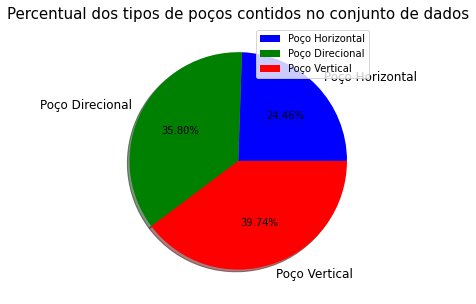

In [74]:
fatias = [763, 1117, 1240]
labels = ['Poço Horizontal', 'Poço Direcional',  'Poço Vertical']
colors = ['blue', 'green', 'red']
explode = [0, 0, 0]
plt.pie(fatias, labels = labels, colors = colors, explode = explode, shadow = True, autopct = "%.2f%%")
plt.title('Percentual dos tipos de poços contidos no conjunto de dados', fontsize = 15)
plt.axis("off")
plt.legend()
plt.show()

**Através do gráfico de barras horizontais abaixo pode-se perceber que a maiorias dos poços exigiu entre 2 a 4 fases. Sendo que a maioria dos poços verticais do conjunto de dados teve de 3 a 5 fases. A maioria dos poços horizontais teve de 1 a 2 fases e os poços direcionais tiveram em maioria de 2 a 4 fases.**

In [75]:
def grafico_barras(caracteristica):
    direcional = dados_cf[dados_cf['tipo_poco']==0][caracteristica].value_counts()
    horizontal = dados_cf[dados_cf['tipo_poco']==1][caracteristica].value_counts()
    vertical = dados_cf[dados_cf['tipo_poco']==2][caracteristica].value_counts()
    df = pd.DataFrame([direcional,horizontal, vertical])
    df.index = ['direcional','horizontal', 'vertical']
    df.plot(kind='barh',stacked=True, figsize=(20,5))

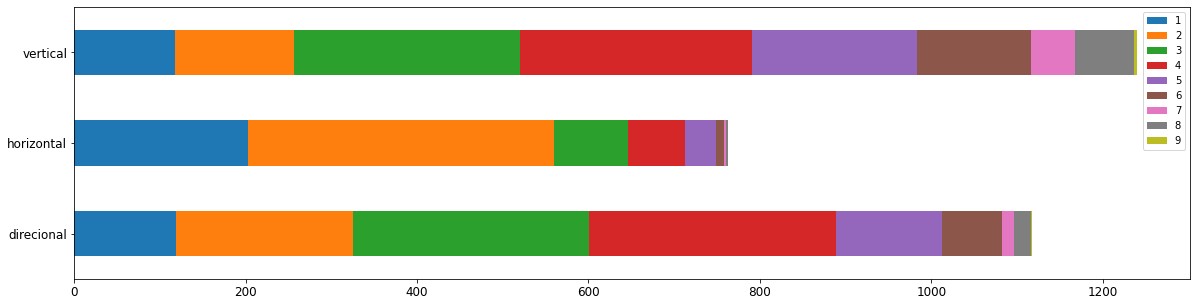

In [76]:
grafico_barras('nfases')

**Através dos gráficos de dispersão e histograma abaixo pode-se ver a  distância entre a superfície do mar até o ponto de perfuração do poço subaquático. Nos gráficos pode-se perceber que dos poços possui entre 600 a 1800 metros de distância entre a superfície do mar até o ponto de perfuração subaquático.**

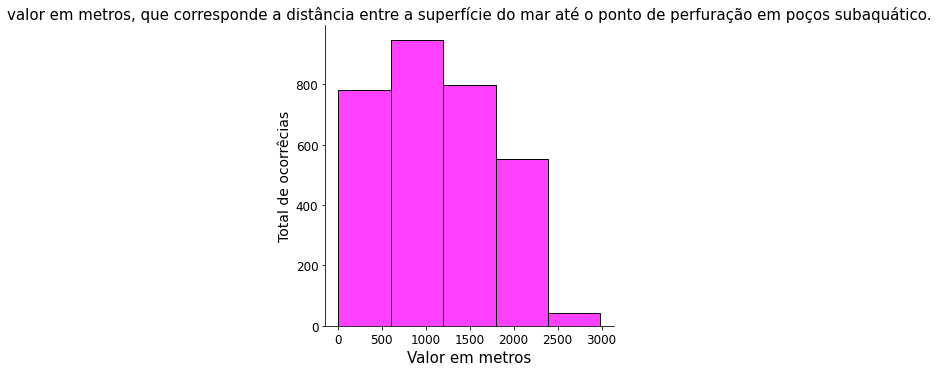

In [79]:
sns.displot(dados_cf.lda, color = 'magenta', bins=5)
plt.title('valor em metros, que corresponde a distância entre a superfície do mar até o ponto de perfuração em poços subaquático.', fontsize = 15)
plt.xlabel('Valor em metros', fontsize = 15)
plt.ylabel('Total de ocorrêcias')
plt.show()

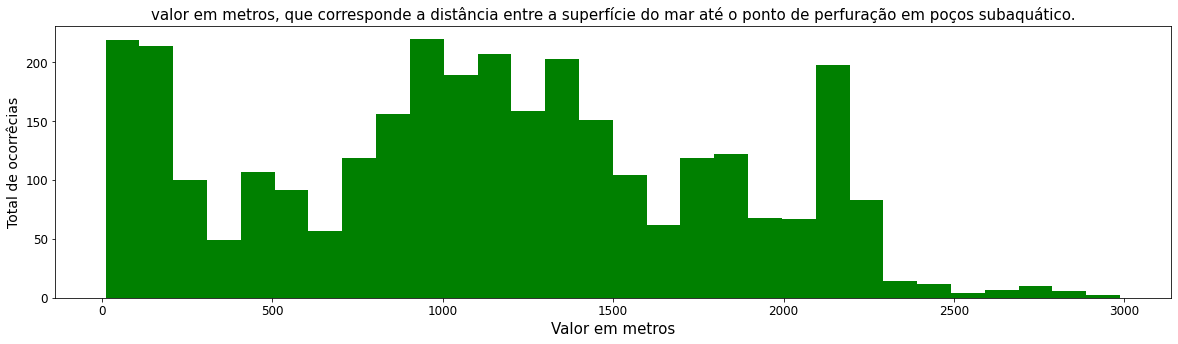

In [81]:
plt.hist(dados_cf.lda, color = 'green', bins=30)
plt.title('valor em metros, que corresponde a distância entre a superfície do mar até o ponto de perfuração em poços subaquático.', fontsize = 15)
plt.xlabel('Valor em metros', fontsize = 15)
plt.ylabel('Total de ocorrêcias')
plt.show()

**Cerca de 25% dos poços tem distância entre a superfície do mar até o ponto de perfuração subaquático menor que 604.75 metros. A mediana em metros é 1123.65, sou seja, 50% dos poços tem distância entre a superfície do mar até o ponto de perfuração subaquático menor que 1123.65. Observa-se que 75% dos poços possui distância entre a superfície do mar até o ponto de perfuração subaquático maior que 1593 metros.**

In [82]:
dados_cf['lda'].describe()

count    3120.000000
mean     1123.653701
std       663.626747
min        10.000000
25%       604.750000
50%      1123.653700
75%      1593.000000
max      2988.000000
Name: lda, dtype: float64

**Separação dos atributos previsores e do targert "tipo_poco".**

In [83]:
X=dados_cf.iloc[:, 2:]

In [84]:
X.head()

,nfases,lda,metragem,dpolegadastotal
0,2,1723.0000,920.500000,16.125000
1,1,1123.6537,331.000000,17.500000
2,6,81.0000,628.000000,17.958333
3,4,307.0000,830.500000,16.062500
4,3,1120.0000,823.666667,12.750000


In [85]:
y = dados_cf.iloc[:,0]

In [86]:
y

0       0
1       0
2       0
3       0
4       0
       ..
3115    2
3116    2
3117    2
3118    2
3119    2
Name: tipo_poco, Length: 3120, dtype: int64

**Através do gráfico de correlação pode-se ver que os atributos não são fortemente correlacionados com a variável alvo "tipo_poco", nem negativamente, nem positivamente.**

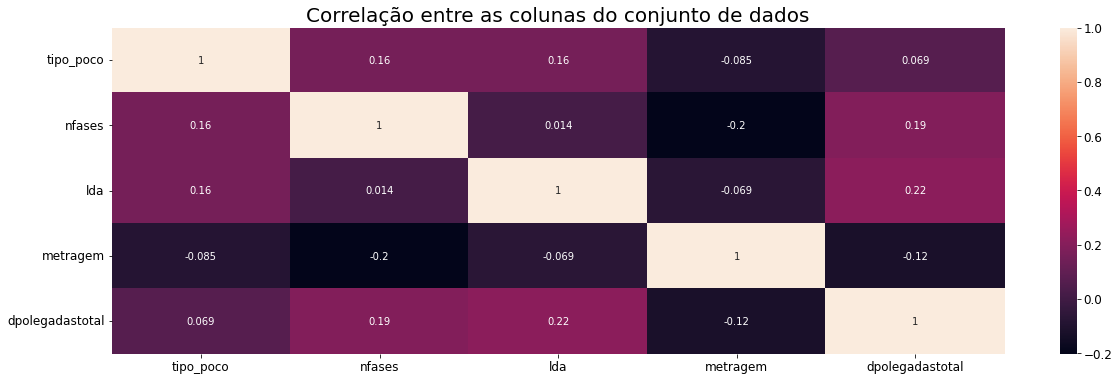

In [87]:
plt.subplots(figsize = (20,6))
sns.heatmap(dados_cf.corr(), annot=True)
plt.title("Correlação entre as colunas do conjunto de dados", fontsize = 20);

In [88]:
#correlação com o target

df_corr = X.copy()
df_corr['tipo_poco'] = y 
df_corr.corr()['tipo_poco'].apply(abs).sort_values(ascending=False)[:]

tipo_poco          1.000000
lda                0.159191
nfases             0.157540
metragem           0.084875
dpolegadastotal    0.069364
Name: tipo_poco, dtype: float64

**Abaixo pode-se ver a importância das variáveis para o target segundo o algoritmo random forest e a biblioteca shap.**

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=0)
X_train.shape

(2808, 4)

**Feature importance**

**Para o random forest as dus colunas mais importantes para o target foram "dpolegadastotal e "lda".**

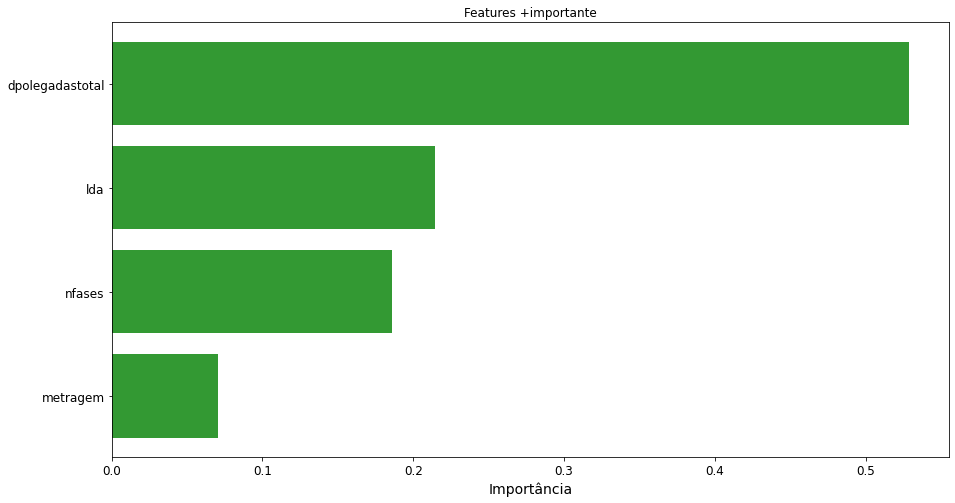

In [ ]:
random_state = 0
max_depth = 5
n_estimators = 250
import matplotlib.pyplot as plt
rfc = RandomForestClassifier(max_depth=max_depth, random_state=random_state, n_estimators=n_estimators)
rfc.fit(X_train, y_train)
importances = rfc.feature_importances_
indices = np.argsort(importances)
features = X_train.columns
plt.figure(figsize=(15,8))
plt.title('Features +importante')
plt.barh(range(len(indices)), importances[indices], color='g', align='center',linestyle="solid",alpha=0.8)
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Importância')
#plt.savefig('Feature_importance.pdf')
plt.show()

**Gráficos gerados com a biblioteca shap.**

**Biblioteca Shap**

In [ ]:
!pip install shap

In [ ]:
import shap

**A biblioteca shape deu bastante importância para a coluna "nfases" e para a coluna "lda".**

  0%|          | 0/2808 [00:00<?, ?it/s]

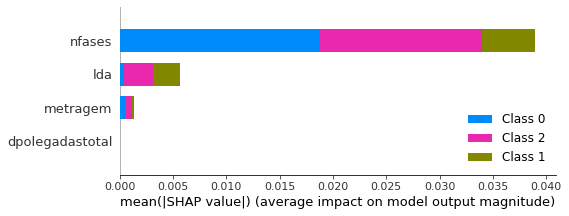

In [ ]:
explainer = shap.KernelExplainer(random_forest.predict_proba,X_train);
shap_values = explainer.shap_values(X_train);
shap.summary_plot(shap_values, X_train);

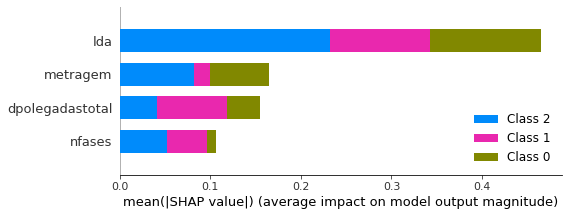

In [ ]:
explainer = shap.TreeExplainer(random_forest)
shap_values = explainer.shap_values(X_train)
shap.summary_plot(shap_values, X_train)

**Influência negativa e positiva dos atributos nas clases a serem previstas.**

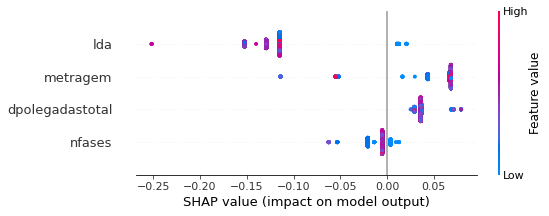

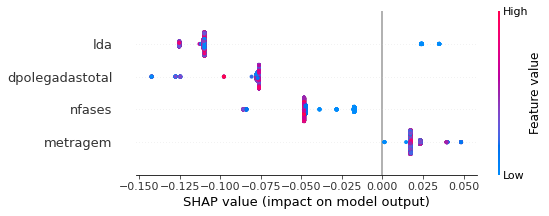

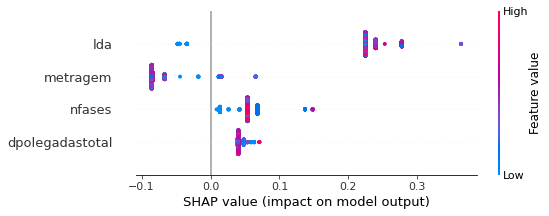

In [ ]:
shap.summary_plot(shap_values[0], X_train)
shap.summary_plot(shap_values[1], X_train)
shap.summary_plot(shap_values[2], X_train)

**Nos algoritmos foram passados os dados sem normalização ou padronização, primeiramente, e depois foram testadas as técnicas de normalização e padronização. Para esse conjunto de dados a técnica de padronização teve melhores resultados.**

**Normalização dos dados**

In [ ]:
escalonamento = MinMaxScaler(feature_range= (0,1))

In [ ]:
X_test=escalonamento.fit_transform(X_test)

**Padronização dos dados**

In [89]:
scaler= StandardScaler()

In [90]:
X = scaler.fit_transform(X)

**Divisão dos dados em treino e teste. Noventa por cento dos dados foram separados para treino e 10% para teste.**

In [91]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=0)
X_train.shape

(2808, 4)

**Foram aplicados alguns algoritmos a fim de classificar os tipos de poços.**

**Abaixo pode-se ver a aplicação da regressão logística, técnica que funciona melhor para classes binárias, a medida que aumenta o número de classes o algoritmo não performa muito bem.**

**Regressão logistica**

In [92]:
logistic_ = LogisticRegression(multi_class='multinomial', solver='lbfgs')
logistic_.fit(X_train, y_train)

LogisticRegression(multi_class='multinomial')

In [93]:
previsoes_lc = logistic_.predict(X_test)


In [94]:
accuracy_score(y_test, previsoes_lc)

0.6121794871794872

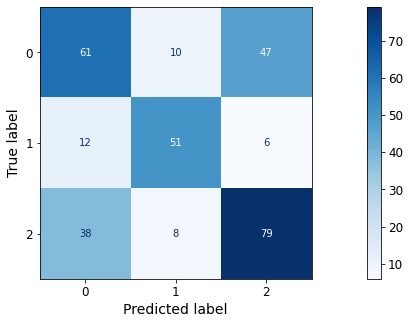

In [95]:
metrics.ConfusionMatrixDisplay.from_predictions(y_test, previsoes_lc, cmap='Blues');
plt.grid(False)

In [96]:
# Imprimindo o relatório de classificação
print("Relatório de classificação: \n", classification_report(y_test, previsoes_lc))  

Relatório de classificação: 
               precision    recall  f1-score   support

           0       0.55      0.52      0.53       118
           1       0.74      0.74      0.74        69
           2       0.60      0.63      0.61       125

    accuracy                           0.61       312
   macro avg       0.63      0.63      0.63       312
weighted avg       0.61      0.61      0.61       312



**Classificação com random forest. A classificação com a técnica random forest foi a que obteve melhores resultados em termos de acurácia, recall, precision e f1-score.**

**Random Forest**

In [ ]:
random_forest = RandomForestClassifier(n_estimators=100, criterion='entropy')
random_forest.fit(X_train, y_train)

RandomForestClassifier(criterion='entropy')

In [ ]:
y_pred_rf = random_forest.predict(X_test)

In [ ]:
accuracy_score(y_test, y_pred_rf)

0.6826923076923077

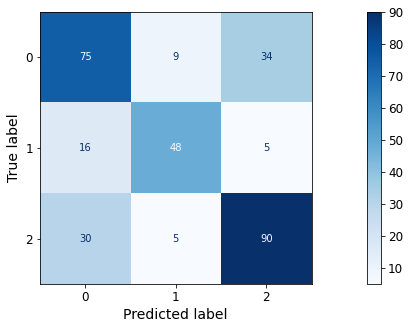

In [ ]:
metrics.ConfusionMatrixDisplay.from_predictions(y_test, y_pred_rf, cmap='Blues');
plt.grid(False)

In [ ]:
# Imprimindo o relatório de classificação
print("Relatório de classificação: \n", classification_report(y_test, y_pred_rf))  

Relatório de classificação: 
               precision    recall  f1-score   support

           0       0.62      0.64      0.63       118
           1       0.77      0.70      0.73        69
           2       0.70      0.72      0.71       125

    accuracy                           0.68       312
   macro avg       0.70      0.68      0.69       312
weighted avg       0.69      0.68      0.68       312



**Também foi aplicado o classificador por votação unitilizando random forest, svm, arvore de decisão e o naive bayes gaussiano.**

**Classificador por votação**

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
GNB= GaussianNB()
dt = DecisionTreeClassifier( criterion='gini',
                                    splitter='best',
                                    max_depth=4,
                                    max_features=1)
rnd_clf = RandomForestClassifier(n_estimators=150, criterion='entropy', max_features=4, max_depth=250, min_samples_split=5)
svm_clf = SVC(kernel='rbf', C = 1)
voting_clf = VotingClassifier(
estimators=[('svc', svm_clf), ('GNB', GNB), ('rf', rnd_clf), ('dt', dt)],
voting='hard')
voting_clf.fit(X_train, y_train)


VotingClassifier(estimators=[('svc', SVC(C=1)), ('GNB', GaussianNB()),
                             ('rf',
                              RandomForestClassifier(criterion='entropy',
                                                     max_depth=250,
                                                     max_features=4,
                                                     min_samples_split=5,
                                                     n_estimators=150)),
                             ('dt',
                              DecisionTreeClassifier(max_depth=4,
                                                     max_features=1))])

In [ ]:
from sklearn.metrics import accuracy_score
for clf in (GNB, svm_clf, rnd_clf, dt, voting_clf):
  clf.fit(X_train, y_train)
  y_pred = clf.predict(X_test)
  print('A acurácia em percentual é: ', clf.__class__.__name__, round(accuracy_score(y_test, y_pred)*100,2), '%')

A acurácia em percentual é:  GaussianNB 60.58 %
A acurácia em percentual é:  SVC 63.14 %
A acurácia em percentual é:  RandomForestClassifier 66.99 %
A acurácia em percentual é:  DecisionTreeClassifier 56.09 %
A acurácia em percentual é:  VotingClassifier 66.03 %


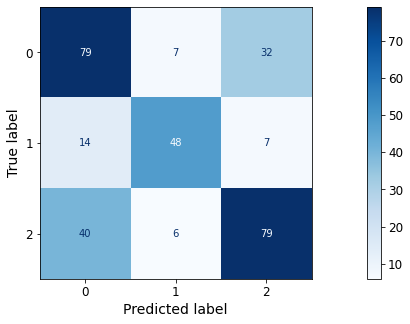

In [ ]:
metrics.ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap='Blues');
plt.grid(False)

In [ ]:
# Imprimindo o relatório de classificação
print("Relatório de classificação: \n", classification_report(y_test, y_pred))  

Relatório de classificação: 
               precision    recall  f1-score   support

           0       0.59      0.67      0.63       118
           1       0.79      0.70      0.74        69
           2       0.67      0.63      0.65       125

    accuracy                           0.66       312
   macro avg       0.68      0.67      0.67       312
weighted avg       0.67      0.66      0.66       312



**Aplicação do Naive Bayes Gaussiano.**

In [ ]:
naive = GaussianNB()
naive.fit(X_train, y_train)

GaussianNB()

In [ ]:
y_prednaive = naive.predict(X_test)

In [ ]:
accuracy_score(y_test, y_prednaive)

0.6057692307692307

**Aplicação do algoritmo arvore de decisão.**

**Árvore de decisão**

In [ ]:
arvore = DecisionTreeClassifier(criterion='entropy', random_state = 0)
arvore.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', random_state=0)

In [ ]:
y_arvore = arvore.predict(X_test)

In [ ]:
accuracy_score(y_test, y_arvore)

0.6153846153846154

**KNN - O KNN utilizando distância de Minkowski conseguiu o segundo melhor resultado, ficando atrás apenas do random forest.**

In [97]:
knn2 = KNeighborsClassifier(n_neighbors=10, metric='minkowski', p = 2)
knn2.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=10)

In [98]:
y_knn2 = knn2.predict(X_test)

In [99]:
accuracy_score(y_test, y_knn2)

0.6698717948717948

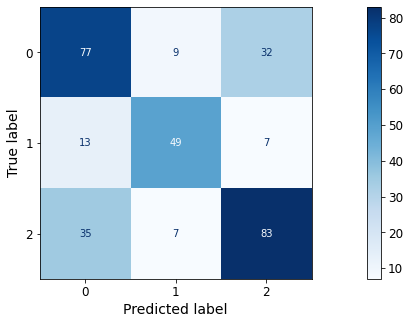

In [100]:
metrics.ConfusionMatrixDisplay.from_predictions(y_test, y_knn2, cmap='Blues');
plt.grid(False)

In [101]:
# Imprimindo o relatório de classificação
print("Relatório de classificação: \n", classification_report(y_test, y_knn2))  

Relatório de classificação: 
               precision    recall  f1-score   support

           0       0.62      0.65      0.63       118
           1       0.75      0.71      0.73        69
           2       0.68      0.66      0.67       125

    accuracy                           0.67       312
   macro avg       0.68      0.68      0.68       312
weighted avg       0.67      0.67      0.67       312



**A MLP teve um resultado de acurácia bem parecido com a do KNN, no entanto não teve boa performance para classificar a classe 0, prejudicando assim seu recall e sua média armônica.**

**MLP**

In [ ]:
# 3 -> 100 -> 100 -> 1
# 3 -> 2 -> 2 -> 1
rede_neural = MLPClassifier(max_iter=1000, verbose=False, tol=0.0000100,
                                   solver = 'adam', activation = 'relu',
                                   hidden_layer_sizes = (200,100))
rede_neural.fit(X_train, y_train)

MLPClassifier(hidden_layer_sizes=(200, 100), max_iter=1000, tol=1e-05)

In [ ]:
y_rn = rede_neural.predict(X_test)


In [ ]:
accuracy_score(y_test, y_rn)

0.6634615384615384

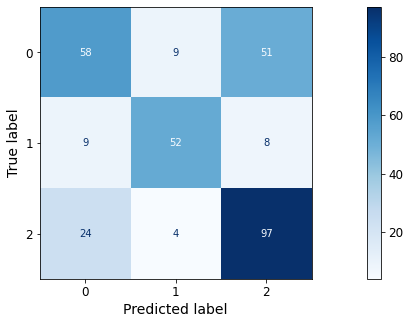

In [ ]:
metrics.ConfusionMatrixDisplay.from_predictions(y_test, y_rn, cmap='Blues');
plt.grid(False)

In [ ]:
# Imprimindo o relatório de classificação
print("Relatório de classificação: \n", classification_report(y_test, y_rn))  

Relatório de classificação: 
               precision    recall  f1-score   support

           0       0.64      0.49      0.56       118
           1       0.80      0.75      0.78        69
           2       0.62      0.78      0.69       125

    accuracy                           0.66       312
   macro avg       0.69      0.67      0.67       312
weighted avg       0.67      0.66      0.66       312



**Classificação com o SVM - SVC.**

**SVM SVC**

In [ ]:
svm = SVC(kernel='rbf', C = 3.0) 
svm.fit(X_train, y_train)

SVC(C=3.0)

In [ ]:
previsoes_svc = svm.predict(X_test)

In [ ]:
accuracy_score(y_test, previsoes_svc)

0.6217948717948718

**Como o random forest foi o algoritmo que obeteve melhores resultados, resolveu-se fazer um tunning de parâmetros do algoritmo.**

**Random Forest Tunning**

In [ ]:
from sklearn.model_selection import GridSearchCV

In [ ]:
parametros = {'criterion': ['gini', 'entropy'],
              'n_estimators': [10, 40, 100, 150],
              'min_samples_split': [2, 5, 10],
              'min_samples_leaf': [1, 5, 10]}

In [ ]:
grid_search = GridSearchCV(estimator=RandomForestClassifier(), param_grid=parametros)
grid_search.fit(X_train, y_train)
melhores_parametros = grid_search.best_params_
melhor_resultado = grid_search.best_score_
print(melhores_parametros)
print(melhor_resultado)

{'criterion': 'gini', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}
0.6937465507069861


**A acurácia do modelo subiu para 69%, aproximadamente, mas o algoritmo acertou menos para a classes zero, mesmo tendo subido ligeiramente para as outras 2 classes.**

In [ ]:
random_forest_tunning = RandomForestClassifier(n_estimators=100, criterion='entropy', min_samples_leaf = 1, min_samples_split = 5)
random_forest_tunning.fit(X_train, y_train)

RandomForestClassifier(criterion='entropy', min_samples_split=5)

In [ ]:
y_pred_rf_tunning = random_forest_tunning.predict(X_test)

In [ ]:
accuracy_score(y_test, y_pred_rf_tunning)

0.6923076923076923

**Matriz de confusão para o random forest tunado.**

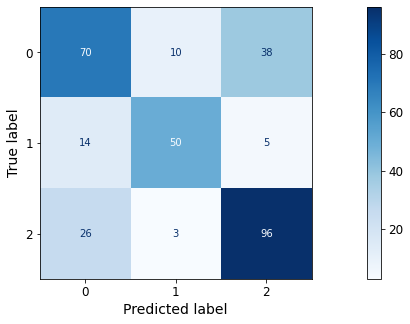

In [ ]:
metrics.ConfusionMatrixDisplay.from_predictions(y_test, y_pred_rf_tunning, cmap='Blues');
plt.grid(False)

**Relatório de classificação para o random forest tunado.**

In [ ]:
# Imprimindo o relatório de classificação
print("Relatório de classificação: \n", classification_report(y_test, y_pred_rf_tunning))  

Relatório de classificação: 
               precision    recall  f1-score   support

           0       0.64      0.59      0.61       118
           1       0.79      0.72      0.76        69
           2       0.69      0.77      0.73       125

    accuracy                           0.69       312
   macro avg       0.71      0.70      0.70       312
weighted avg       0.69      0.69      0.69       312



###**Conclusão**

**Neste case foram aplicadas a similaridade por cosseno e a distância euclidiana a fim de encontrar os 4 poços mais correlacionados com um poço passado como entrada (as características do posso). O posso passado como entrada foi o poço 001L7P. Usando a similaridade por cosseno para conseguir as 4 maiores correlações, obteve-se que os poços 01UR62,	ZUSIAU,	00WI6A e	00OCZ3 foram os mais correlacionados com o poço de entrada. Já na aplicação da distância euclidiana os poços com mínimas distâncias e consequentemente com mais similaridade, ou seja, mais correlacionados foram os poços,	5TN53E,	1FPJ3C,	65K1WS e  N63S39. Como algo a mais a ser mostrado o candidato aplicou algoritmos de classificação para classificar o tipo de poço, se direcional, horizontal ou vertical. Os atributos não tiveram forte correlação com o target nem negativamente, nem positivamente, mas conseguiu-se melhorar os resultados das performances dos algoritmos em relação aos dados aplicados como eram por padrão, com técnicas de normalização e padronização dos dados, além das escolhas dos parâmetros dos algoritmos. O classificador utilizando random forest foi o que obteve melhores resultados, com cerca de 68% de acurácia. O segundo melhor classificador foi o KNN com acurácia de 67%, aproximadamente. Foram aplicados também outros classificadores como classificador por votação e a rede neural mlp, que teve resultado de acurácia semelhante ao KNN, porém obteve maiores erros para uma determinada classe, comprometendo seu recall e sua média armônica (f1-score). Foi também tunado o algoritmo random forest, que obteve um valor de acurácia levemente acima do classificador random forest aplicado anteriormente, acertou mais para 2 classes, no entanto, teve mais erros para uma determinada classe comparado com o random forest sem tunning, o random forest sem tunning foi um pouco mais balanceado, e portanto, na visão do candidato, o mais adequado como modelo, se fosse utilizado, mas ressalta-se novamente que os atributos não conseguiram explicar bem o modelo, por isso o algoritmo não performou melhor. Ainda foi feita uma técnica de balanceamento das classes usando a biblioteca Adasyn, entretanto os resultados pioraram, então o candidato resolveu não mostrar esses resultados. Por fim, conclui-se que na classificação do tipo de poço o modelo com random forest foi o melhor para esse conjunto de dados.**

Relatório de classificação random forest: 
               precision    recall  f1-score   support

           0       0.62      0.64      0.63       118
           1       0.77      0.70      0.73        69
           2       0.70      0.72      0.71       125

    accuracy                           0.68       312
   

   Relatório de classificação KNN: 
               precision    recall  f1-score   support

           0       0.62      0.65      0.63       118
           1       0.75      0.71      0.73        69
           2       0.68      0.66      0.67       125

    accuracy                           0.67       312
   

